<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/MLP_Basic_Step_by_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP Progresivo: De Básico a Optimizado

## Máster de FP en Business Analytics e IA
### Profesor: Álvaro López Barbera

En este notebook construiremos 5 modelos progresivamente mejores:

1. Modelo Básico (sin regularización)
2. Modelo con Dropout
3. Modelo con Batch Normalization
4. Modelo con L2 Regularization
5. Modelo Optimizado Final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)
import warnings
warnings.filterwarnings('ignore')

print('Librerías cargadas')

Librerías cargadas


## Preprocesamiento de Datos

In [2]:
df = sns.load_dataset('titanic')
df_model = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone', 'survived']].copy()

df_model['age'].fillna(df_model['age'].median(), inplace=True)
df_model['fare'].fillna(df_model['fare'].median(), inplace=True)
df_model['embarked'].fillna(df_model['embarked'].mode()[0], inplace=True)

df_model['sex'] = (df_model['sex'] == 'male').astype(int)
embarked_dummies = pd.get_dummies(df_model['embarked'], prefix='embarked', drop_first=True)
df_model = pd.concat([df_model, embarked_dummies], axis=1)
df_model.drop('embarked', axis=1, inplace=True)

X = df_model.drop('survived', axis=1)
y = df_model['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Datos preparados: {X_train.shape[0]} train, {X_test.shape[0]} test')

Datos preparados: 712 train, 179 test


In [3]:
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre):
    y_train_pred = (modelo.predict(X_train, verbose=0) > 0.5).astype(int).flatten()
    y_test_pred = (modelo.predict(X_test, verbose=0) > 0.5).astype(int).flatten()

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f'\n{nombre}:')
    print(f'  Train Accuracy: {train_acc:.4f}')
    print(f'  Test Accuracy:  {test_acc:.4f}')
    print(f'  Overfitting: {(train_acc - test_acc):.4f}')

    return {'nombre': nombre, 'train_acc': train_acc, 'test_acc': test_acc, 'overfitting': train_acc - test_acc}

resultados = []

## MODELO 1: Básico (Sin Regularización)

In [4]:
print('MODELO 1: Básico')

modelo_1 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

modelo_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_1.summary()

MODELO 1: Básico


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history_1 = modelo_1.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_1 = evaluar_modelo(modelo_1, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 1')
resultados.append(resultado_1)


MODELO 1:
  Train Accuracy: 0.8750
  Test Accuracy:  0.7765
  Overfitting: 0.0985


## MODELO 2: Con Dropout

In [6]:
print('MODELO 2: Con Dropout')

modelo_2 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

modelo_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_2.summary()

MODELO 2: Con Dropout


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history_2 = modelo_2.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_2 = evaluar_modelo(modelo_2, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 2')
resultados.append(resultado_2)


MODELO 2:
  Train Accuracy: 0.8511
  Test Accuracy:  0.7877
  Overfitting: 0.0634


## MODELO 3: Con Batch Normalization

In [8]:
print('MODELO 3: Con BatchNorm + Dropout')

modelo_3 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

modelo_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_3.summary()

MODELO 3: Con BatchNorm + Dropout


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,489 (13.63 KB)

 Non-trainable params: 224 (896.00 B)

In [9]:
history_3 = modelo_3.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_3 = evaluar_modelo(modelo_3, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 3')
resultados.append(resultado_3)


MODELO 3:
  Train Accuracy: 0.8483
  Test Accuracy:  0.7933
  Overfitting: 0.0550


## MODELO 4: Con L2 Regularization

In [10]:
print('MODELO 4: Con L2')

modelo_4 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

modelo_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_4.summary()

MODELO 4: Con L2


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,489 (13.63 KB)

 Non-trainable params: 224 (896.00 B)

In [11]:
history_4 = modelo_4.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
resultado_4 = evaluar_modelo(modelo_4, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 4')
resultados.append(resultado_4)


MODELO 4:
  Train Accuracy: 0.8525
  Test Accuracy:  0.7654
  Overfitting: 0.0872


## MODELO 5: Optimizado Final

In [12]:
print('MODELO 5: Optimizado')

modelo_5 = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

modelo_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelo_5.summary()

MODELO 5: Optimizado


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,489 (13.63 KB)

 Non-trainable params: 224 (896.00 B)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

history_5 = modelo_5.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

resultado_5 = evaluar_modelo(modelo_5, X_train_scaled, y_train, X_test_scaled, y_test, 'MODELO 5')
resultados.append(resultado_5)


MODELO 5:
  Train Accuracy: 0.8553
  Test Accuracy:  0.8156
  Overfitting: 0.0397


## Comparación de Modelos

In [14]:
df_resultados = pd.DataFrame(resultados)
print('\nComparación de Modelos:')
print(df_resultados)

mejor_idx = df_resultados['test_acc'].idxmax()
print(f'\nMejor Modelo: {df_resultados.iloc[mejor_idx]["nombre"]}')
print(f'Test Accuracy: {df_resultados.iloc[mejor_idx]["test_acc"]:.4f}')


Comparación de Modelos:
     nombre  train_acc  test_acc  overfitting
0  MODELO 1   0.875000  0.776536     0.098464
1  MODELO 2   0.851124  0.787709     0.063414
2  MODELO 3   0.848315  0.793296     0.055019
3  MODELO 4   0.852528  0.765363     0.087165
4  MODELO 5   0.855337  0.815642     0.039695

Mejor Modelo: MODELO 5
Test Accuracy: 0.8156


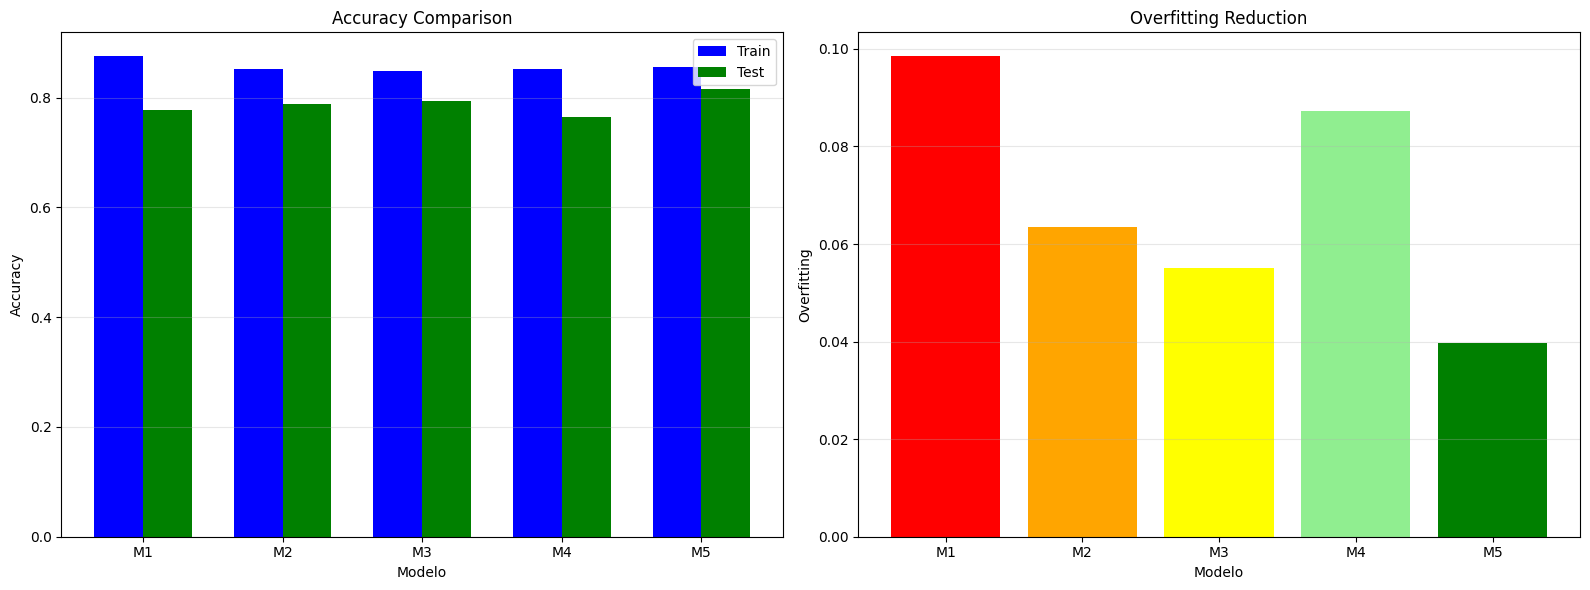

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_pos = np.arange(len(df_resultados))
width = 0.35

axes[0].bar(x_pos - width/2, df_resultados['train_acc'], width, label='Train', color='blue')
axes[0].bar(x_pos + width/2, df_resultados['test_acc'], width, label='Test', color='green')
axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(['M1', 'M2', 'M3', 'M4', 'M5'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x_pos, df_resultados['overfitting'], color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
axes[1].set_xlabel('Modelo')
axes[1].set_ylabel('Overfitting')
axes[1].set_title('Overfitting Reduction')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['M1', 'M2', 'M3', 'M4', 'M5'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluación del Mejor Modelo

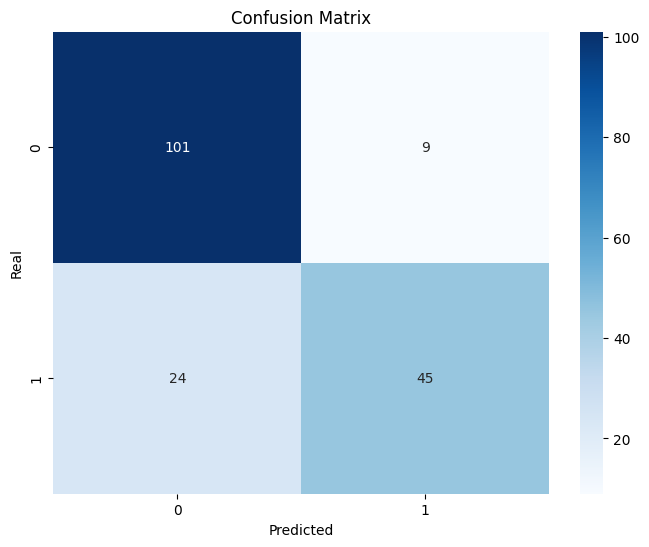


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       110
           1       0.83      0.65      0.73        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



In [16]:
y_pred_proba = modelo_5.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

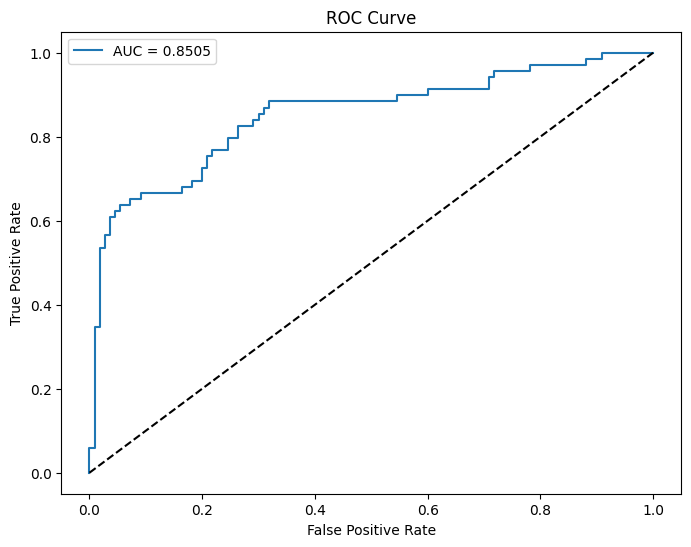

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Conclusiones

Hemos visto cómo mejorar progresivamente un modelo MLP:

- **MODELO 1**: Baseline con overfitting
- **MODELO 2**: Dropout reduce overfitting
- **MODELO 3**: BatchNorm estabiliza entrenamiento
- **MODELO 4**: L2 controla pesos
- **MODELO 5**: Combinación óptima con callbacks

Técnicas clave:
- Dropout para regularización
- Batch Normalization para estabilidad
- L2 para control de pesos
- Early Stopping para evitar sobreentrenamiento
- ReduceLROnPlateau para optimización